In [11]:
import torch
from torch_geometric.data import Data, DataLoader
from cnf import BipartiteData
from loss import LossCompute, AccuracyCompute, push_to_side, linear_loss, log_loss
import time
import numpy as np
import matplotlib.pyplot as plt
from utils import load_checkpoint

In [2]:
# add a folder raw under dataset manually before execute this chunk
from data import SATDataset
ds = SATDataset('../dataset', 'RND3SAT/uf50-218', False)
last_trn, last_val = int(len(ds)), int(len(ds))
train_ds = ds[: last_trn]
valid_ds = ds[last_trn: last_val]
test_ds = ds[last_val:]

In [3]:
test_data = train_ds[1]
edge_index_pos = test_data.edge_index_pos
edge_index_neg = test_data.edge_index_neg
variable_count = max(max(edge_index_pos[1]), max(edge_index_neg[1])) + 1
clause_count = len(edge_index_pos[1])

# Debug for loss.py

In [4]:
def test_loss(iter_num, par_sm, par_sg, var_num, plot=False):
    loss_func = LossCompute(par_sm, par_sg, metric=linear_loss, debug=True)
    sat_rate = np.zeros(iter_num)
    loss_v = np.zeros(iter_num)
    for i in range(iter_num):
        x_s = push_to_side(torch.rand(var_num, 1), par_sg)
        loss, sm = loss_func(x_s, edge_index_pos, edge_index_neg, clause_count=218, is_train=False)
        satisfied_percentage = sum(sm > 0.5).numpy() / clause_count
        loss_v[i] = loss
        sat_rate[i] = satisfied_percentage
    if plot:
        plt.plot(sat_rate, loss_v, "ro")
        plt.xlabel("Satisfied Clauses / Numer of Clauses")
        plt.ylabel("Loss")
    return sat_rate, loss_v

Time for loss1 and loss2 to compute loss of 5000 FG respectively takes 6.228049039840698s


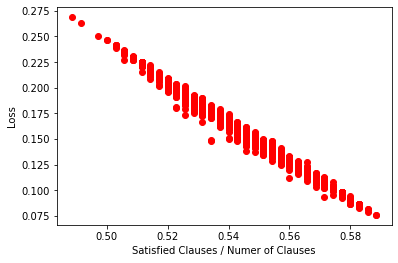

In [5]:
start = time.time()
sat_rate, loss_v = test_loss(5000, 30, 50, variable_count, plot=True)
span = time.time() - start
print(f"Time for loss1 and loss2 to compute loss of 5000 FG respectively takes {span}s")

# Debug for models.py

In [6]:
import models
from args import make_args

In [7]:
class Args():
    def __init__(self):
        self.dataset = 'RND3SAT/uf50-218'
        self.dataset_root = '../dataset'
        self.loss = 'l2'
        self.use_gpu = True
        self.cuda = '0'
        self.graph_valid_ratio = 0.1
        self.graph_test_ratio = 0.1
        self.feature_transform = False
        self.drop_rate = 0.5
        self.speedip = False
        self.load_model = False
        self.batch_size = 1
        self.num_layers = 2
        self.num_encoder_layers = 2
        self.num_decoder_layers = 2
        self.num_meta_paths = 4
        self.encoder_channels = '1,16,32'
        self.decoder_channels = '32,16,16'
        self.self_att_heads = 8
        self.cross_att_heads = 8
        self.lr = 1e-6
        self.p = 1e-3
        self.a = 1e-3
        self.warmup_steps = 200
        self.opt_train_factor = 4
        self.epoch_num = 201
        self.epoch_log = 50
        self.epoch_save = 50
        self.save_root = 'saved_model'
        self.root = '../dataset'

## sample a test data

In [20]:
args = Args()
device = torch.device('cuda:0') if args.use_gpu and torch.cuda.is_available() else torch.device('cpu')
# device = 'cuda' if torch.cuda.is_available() else 'cpu
# download and save the dataset
dataset = SATDataset(args.root, args.dataset, use_negative=False)
test_loader = DataLoader(dataset[:2],
                             batch_size=1,
                             shuffle=True)

## Initialize a model and to make it run through

In [21]:
model = models.make_model(args)
path = '../saved_model/check_point200.pickle'
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])
loss_func = LossCompute(30, 50, metric=linear_loss, debug=True)
accuracy = AccuracyCompute()
for batch in test_loader:
    xv = model(batch)
    print(xv)
    print(xv // 0.5)
    loss, sm = loss_func(xv, batch.edge_index_pos, batch.edge_index_neg, clause_count=218, is_train=False)
    acc = accuracy(xv, batch.edge_index_pos, batch.edge_index_neg)
    print(acc)
    print()

tensor([[6.0446e-34],
        [1.0000e+00],
        [1.4013e-45],
        [2.8026e-45],
        [1.0000e+00],
        [2.6625e-44],
        [1.0000e+00],
        [0.0000e+00],
        [1.0000e+00],
        [2.8026e-45],
        [5.6052e-45],
        [1.0000e+00],
        [8.4078e-45],
        [1.4013e-45],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [0.0000e+00],
        [4.2039e-45],
        [1.0000e+00],
        [1.0000e+00],
        [2.8026e-45],
        [1.4013e-45],
        [0.0000e+00],
        [0.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.1911e-43],
        [2.6608e-37],
        [1.0000e+00],
        [3.1809e-43],
        [1.0000e+00],
        [1.4013e-45],
        [1.0000e+00],
        [5.6052e-44],
        [1.0000e+00],
        [1.0000e+00],
        [1.4013e-45],
        [1.4013e-45],
        [0.0000e+00],
        [1.4013e-45],
        [0.0000e+00],
        [6.6421e-40],
        [0.0000e+00],
        [7

In [23]:
1 // 0.50001

1.0

# After finish model.py, debug train.py